In [ ]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer.primitives import Sampler as AerSampler


# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(len(x))]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

# Introduction to Quantum Computing & Financial Optimization with Qiskit
National University of Singapore<br>
April 9, 2024<br>
<br>

Stefan Woerner<br>
IBM Quantum, IBM Research Europe - Zurich<br>
<href>wor@zurich.ibm.com</href>
<br>

https://github.com/stefan-woerner/2024-04-09_nus_quantum_optimization

# Outline

1. Introduction to Quantum Computing & Qiskit

2. Introduction to Quantum Optimization

3. Introduction to Qiskit Optimization

4. Optimization via Ising Hamiltonians

5. An Illustrative Application in Finance

6. Running a first Experiment on a Quantum Computer

# 1. Introduction to Quantum Computing

1. Quantum Circuits and Gates
2. Single-qubit circuits
2. Two-qubit circuits
3. Qiskit Sampler

In [ ]:
from qiskit.circuit import Parameter
from qiskit.circuit.library import XGate, YGate, ZGate, RYGate, HGate, CXGate, CZGate


theta = np.pi/4
single_qubit_gates = [XGate(), YGate(), ZGate(), HGate(), RYGate(theta)]
two_qubit_gates = [CXGate(), CZGate()]

In [ ]:
for gate in single_qubit_gates:
    print('gate:', gate.name)
    qc = QuantumCircuit(gate.num_qubits)
    qc.append(gate, range(gate.num_qubits))
    print(qc)
    print(gate.to_matrix())


In [ ]:
for gate in two_qubit_gates:
    print('gate:', gate.name)
    qc = QuantumCircuit(gate.num_qubits)
    qc.append(gate, range(gate.num_qubits))
    print(qc)
    print(gate.to_matrix())

In [ ]:
# initialize 1-qubit quantum circuit
qc = QuantumCircuit(1)

# bit flip
qc.x(0)

# equal superposition
# qc.h(0)

# y-rotation
# qc.ry(np.pi/4, 0)

# draw circuit
print(qc)

# plot probabilities
sv = Statevector(qc)
print(sv.data)
plot_histogram(sv.probabilities_dict(), figsize=(4, 4))

In [ ]:
# initialize 2-qubit quantum circuit
qc = QuantumCircuit(2)

# Bell state
qc.h(0)
# qc.ry(np.pi/4, 0)  # comment out to bias distribution
qc.cx(0, 1)
print(qc)

# plot probabilities
sv = Statevector(qc)
print(sv.data)
plot_histogram(sv.probabilities_dict(), figsize=(4, 4))

In [ ]:
# sampler
sampler = AerSampler(run_options={'shots': 100})

# initialize 2-qubit quantum circuit
qc = QuantumCircuit(2)

# Bell state
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
print(qc)

job = sampler.run(qc)
probabilities = job.result().quasi_dists[0].binary_probabilities()
plot_histogram(probabilities, figsize=(4, 4))

# 2. Introduction to Quantum Optimization


# "Quantum Computers can evaluate all possible solutions at the same time..."

# <font color="red">"Quantum Computers can evaluate all possible solutions at the same time..."</font>
## $\rightarrow$ A common misunderstanding, particularly for combinatorial optimization!

Suppose the equal superposition state

$$
|+\rangle_n = H^{\otimes n} |0\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n
$$

Furthermore, suppose a function $f: \{0, \ldots, 2^n-1\} \rightarrow \mathbb{R}$ and a corresponding quantum operation

$$
F: |x\rangle_n|0\rangle_m \mapsto |x\rangle_n|f(x)\rangle_m
$$

Thus, we get

$$
F |+\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n|f(x)\rangle_m
$$

and the quantum computer evaluates the exponential number of solultions in parallel! 

Doesn't it?

Unfortunately,
- it remains an exponential number of possible solutions.
- the quantum computer does NOT tell us which one achieves the optimum.
- if we measure the qubits in the state above, we just sample every possible solution with the same probability of $1/2^n$, as we could easily do classically.
<br>
<br>
<br>
<font color="orange">$\rightarrow$ To get a quantum computer to tell us the optimal solution of a combinatorial optimization problem with probability higher than $1/2^n$, we have to work a bit harder...</font>

# 3. Qiskit Optimization

# Qiskit's Optimization Module

<br>
<div>
    <center>
        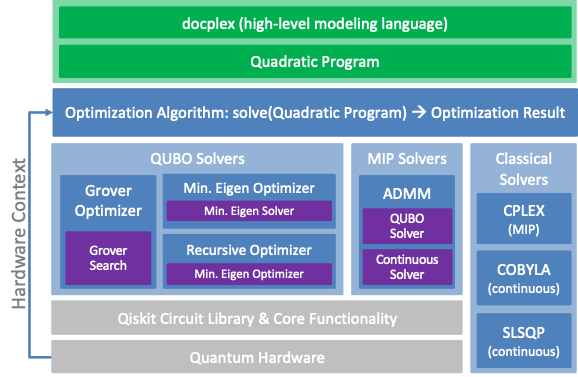
        <br>
        https://medium.com/qiskit: A Walkthrough of Qiskit’s New Optimization Module
    </center>
</div>

## Quadratically Constrained Quadratic Programs

<br>

$$
\min_{x \in X} \, x^T A x + b^T x + c \\
\, \\
\text{subject to}\\
x^T A_i x + b_i^T x + c_i \leq 0, \quad i=1, \ldots, r,\\
\, \\
\text{where}\\
X = \mathbb{R}^n \times \mathbb{Z}^m \times \{0, 1\}^k\\
A \in \mathbb{R}^{(n+m+k) \times (n+m+k)}\\
b \in \mathbb{R}^{(n+m+k)}\\
c \in \mathbb{R}
$$

## Quadratic Unconstrained Binary Optimization (QUBO)

<br>

$$
\min_{x \in \{0, 1\}^k} \, x^T A x + c \\
$$

For binary variables $x^2 = x$, thus, the linear part can be added to the diagonal of the quadratic part.

## Example: MaxCut

In [ ]:
# create graph
G = nx.Graph()

# add nodes
n = 5
G.add_nodes_from(range(n))

# add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

# plot graph
plot_result(G, [0]*n)

## Example: Modeling MaxCut with DOCPLEX

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

In [ ]:
from docplex.mp.model import Model

mdl = Model('MaxCut')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

objective = mdl.sum([ w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])
mdl.maximize(objective)

mdl.prettyprint()

## Example: Adding a Constraint

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = b
$$

In [ ]:
b = 2
mdl.add_constraint(mdl.sum(x) == b)
mdl.prettyprint()

## Example: Create and solve `QuadraticProgram` with DOCPLEX

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver


# convert from DOcplex model to Qiskit Quadratic Program
# qp = QuadraticProgram()
qp = from_docplex_mp(mdl)

# Solve Quadratic Program using CPLEX
optimizer = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = optimizer.solve(qp)
print(result)
plot_result(G, result.x)

## Questions?

# 4. Optimization via Ising Hamiltonian

## Conversion to QUBO

Qiskit's Optimization module provides converters for Quadratic Programs:

In [ ]:
from qiskit_optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints via slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)

## Linear Equality Constraint to Quadratic Penalty Term

In [ ]:
lineq2penalty = LinearEqualityToPenalty(penalty=1)
qp_wo_constr = lineq2penalty.convert(qp)
print(qp_wo_constr.prettyprint())

In [ ]:
# Solve converted Quadratic Program using CPLEX
result = optimizer.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)

## Mapping of QUBO to Ising Hamiltonian

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

1. Substitute<br>
$x_i = (1 - z_i)/2,$<br>
where $z_i \in \{-1, +1\}$.
<br>

2. Replace<br>
$z_i z_j = \sigma_Z^i \otimes \sigma_Z^j$, and<br>
$z_i = \sigma_Z^i$,<br>
where $\sigma_Z^i$ denotes the Pauli Z-matrix $\left(\begin{array}{cc}1&0\\0&-1\end{array}\right)$ on the <font color="blue">$i$-th qubit</font>.

## From QUBO to Finding Hamiltonian Groundstates

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

which has been mapped to an Ising Hamiltonian:
$$
H = \sum_{i,j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i + \tilde{c}
$$

Finding the groundstate of $H$ is equivalent to solving the QUBO:

$$
\min_{|\psi\rangle_n} \, \langle \psi |H| \psi \rangle_n
$$

<br>

<b>Remark:</b> $H$ is diagonal, and thus, all computational basis states $|x\rangle_n$ are eigenstates.

In [ ]:
H, offset = qp_wo_constr.to_ising()
print('offset =', offset)
print()
print('H =', H)

In [ ]:
# print Ising Hamiltonian as matrix
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 3.5))
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Variational Quantum Eigensolver (VQE)

Replace minimization over all $|\psi\rangle$ by minimization over a parametrized subset $|\psi(\theta)\rangle$:
<br>

$$
\min_{\theta} \langle \psi(\theta) |H| \psi(\theta) \rangle
$$

## VQE with `RealAmplitudes` Circuit

In [ ]:
from qiskit.circuit.library import RealAmplitudes

qc = RealAmplitudes(5, reps=1, insert_barriers=True)
qc.decompose().draw('mpl', fold=120)

In [ ]:
# run VQE
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA

aer_sampler = AerSampler()
vqe = SamplingVQE(aer_sampler, qc, COBYLA())
result = vqe.compute_minimum_eigenvalue(H)
print('optimal value:', np.round(result.eigenvalue, decimals=4))

# plot probabilities
probabilities = np.array([result.eigenstate.get(i, 0.0) for i in range(2**n)])
plt.figure(figsize=(12, 4))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How should we choose $|\psi(\theta)\rangle$ for a particular problem?

## The Adiabatic Theorem
> A physical system remains in its instantaneous eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. <br><br>
> M. Born and V. A. Fock (1928). "Beweis des Adiabatensatzes".<br>Zeitschrift für Physik A. 51 (3–4): 165–180.<br>
https://en.wikipedia.org/wiki/Adiabatic_theorem

## Trotterized Annealing: General Idea

Given a cost Hamiltonian $H_C$ that encodes a QUBO:
1. Find simple Hamiltonian $H_X$ with easy-to-prepare groundstate $|\psi_0\rangle$<br>that has non-zero overlap with the groundstate of $H_C$.

2. Slowly drive the system away from $|\psi_0\rangle$ over time $t \in [0, T]$, following the dynamics defined by the time-dependent Hamiltonian
$$
H_t = \frac{t}{T} H_C + (1 - \frac{t}{T}) H_X.
$$

If done slowly enough, the Adiabatic Theorem implies that the system will stay in the groundstate of $H_t$ for all $t$. Thus, will end in the groundstate $H_C$, i.e., the optimal solution of the QUBO.

## Trotterized Annealing: Common Setting

A common choice is

$$
H_X = -\sum_{i=1}^n \sigma_X^i,
$$

where $\sigma_X^i$ denotes the Pauli X-matrix on qubit $i$.
The corresponding groundstate is given by

$$
|\psi_0\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} |k\rangle.
$$

This state has overlap with every other state and can be easily prepared using Hadamard gates.

## Trotterized Annealing: Single Qubit Example

Suppose

$$
H_C = \sigma_Z = 
\left(\begin{array}{cc}
1 & 0 \\ 0 & -1
\end{array}\right)
$$

with <font color="blue">groundstate $|1\rangle$ and optimal value -1</font>.
Then,

$$
H_t = \frac{t}{T} \sigma_Z - (1 - \frac{t}{T}) \sigma_X.
$$

The annealing process can then be approximated by setting

$$ 
|\psi_{t+1}\rangle = e^{-iH_t \Delta t}|\psi_{t}\rangle
$$

for a small time step $\Delta t$. The matrices $\sigma_Z$ and $\sigma_X$ do not commute, however, we can trotterize, i.e., we first apply $e^{-i \frac{t}{T} H_C \Delta t}$ and then $e^{-i (1 - \frac{t}{T}) H_X \Delta t}$, and for sufficiently small $\Delta t$ only introduce a small error.

Thus, we have

$$
e^{-i \frac{t}{T} H_C \Delta t} = e^{-i \sigma_Z \frac{\gamma_t}{2}} = R_Z(\gamma_t),
$$

and

$$
e^{-i (1 - \frac{t}{T}) H_X \Delta t} = e^{-i \sigma_X \frac{\beta_t}{2}} = R_X(\beta_t)
$$

for rotation angles $\gamma_t = 2 t/T \Delta t$ and $\beta_t = -2(1 - t/T) \Delta t$.

In [ ]:
from qiskit.circuit import Parameter
gamma, beta = Parameter('gamma'), Parameter('beta')

qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
qc.rz(gamma, 0)
qc.rx(beta, 0)
qc.barrier()
qc.draw()

In [ ]:
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas

In [ ]:
T = 5
N = 10
gammas, betas = construct_schedule(T, N)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, T, N+1), gammas, label='gammas')
plt.plot(np.linspace(0, T, N+1), betas, label='betas')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('parameters', fontsize=14);

In [ ]:
# track probabilities during trotterized annealing
probabilities = np.zeros((2, N+1))

# construct circuit
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
for i, (gamma, beta) in enumerate(zip(gammas, betas)):
    qc.rz(gamma, 0)
    qc.rx(beta, 0)
    qc.barrier()
    probabilities[:, i] = Statevector.from_instruction(qc).probabilities()
qc.draw()

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[1, :], 'gd-', label=r'$|1\rangle$')
plt.plot(np.linspace(0, T, N+1), probabilities[0, :], 'bo-', label=r'$|0\rangle$')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('probabilities', fontsize=14);

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[0, :] - probabilities[1, :], 'gd-')
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('objective value', fontsize=14);

## Trotterized Annealing: Multiple Qubits

Suppose an Ising Hamiltonian corresponding to a QUBO:
$$
H_C = \sum_{i\neq j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i.
$$
Since all terms are diagonal and commute, we have 

$$
e^{-iH_C\gamma} = \prod_{i\neq j=0}^{n-1} e^{-i \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j \gamma} \, \prod_{i=0}^{n-1} e^{-i \tilde{b}_i \sigma_Z^i \gamma}
$$

For $\sigma_Z^i$, this again results in $R_Z$ gates.

For $\sigma_Z^i \otimes \sigma_Z^j$, we need to implement
$R_{ZZ}(\gamma) = e^{-i \sigma_Z^i \otimes \sigma_Z^j \gamma/2}$.

For $H_X$ we can just apply single qubit $R_X$ gates.

$R_{ZZ}(\gamma)$ can be constructed as follows:

In [ ]:
gamma = Parameter('gamma')
qc1 = QuantumCircuit(2)
qc1.cx(0, 1)
qc1.rz(gamma, 1)
qc1.cx(0, 1)
qc1.draw('mpl')

or using the implementation directly provided by Qiskit:

In [ ]:
qc2 = QuantumCircuit(2)
qc2.rzz(gamma, 0, 1)
qc2.draw('mpl')

## Trotterized Annealing: MaxCut

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

# construct parameters from annealing schedule
T = 5
N = 20
gammas, betas = construct_schedule(T, N)

# construct variational form
qc = QAOAAnsatz(cost_operator=H, reps=N+1)

# evaluate circuit
params = np.array([[gammas[i], betas[i]] for i in range(N+1)]).flatten()
sv = Statevector.from_instruction(qc.assign_parameters(params))

In [ ]:
# plot probabilities
probabilities = sv.probabilities()
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
# draw trotterized annealing circuit for MaxCut
qc.decompose(reps=3).draw('mpl')

## From Trotterized Annealing to the<br>Quantum Approximate Optimization Algorithm (QAOA)

Trotterized Annealing leads to very long circuits, since the required simulation time and number of Trotter steps significantly increases with the problem size.

Thus, as introduced in [1], one can fix the number of steps to $p$, and let a classical optimizer find the best angles $\gamma_t$ and $\beta_t$, $t = 1, \ldots, p$, instead of following a fixed annealing schedule.

This is known as the <font color="blue"><b>Quantum Approximate Optimization Algorithm</b></font>.

<br>
<br>
[1] A Quantum Approximate Optimization Algorithm.<br>Edward Farhi, Jeffrey Goldstone, Sam Gutmann.<br>
https://arxiv.org/abs/1411.4028

## QAOA: Single Qubit Example $H_C = \sigma_Z$

In [ ]:
# QAOA circuit for p = 1
gamma, beta = Parameter('gamma'), Parameter('beta')
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(gamma, 0)
qc.rx(beta, 0)

def objective(params):
    qc_ = qc.assign_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]

optimizer = COBYLA()
result = optimizer.minimize(objective, [0.5, 0.5])
print('optimal params:', np.round(result.x, decimals=4))
print('optimal value: ', np.round(result.fun, decimals=4))
print('optimal state: ', np.round(Statevector.from_instruction(qc.assign_parameters(
    {gamma: result.x[0], beta: result.x[1]})).data, decimals=4))

## QAOA: MaxCut

In [ ]:
# illustrating the QAOA var form
p = 1
qc = QAOAAnsatz(cost_operator=H, reps=p)
qc.decompose(reps=3).draw('mpl')

In [ ]:
from qiskit_algorithms import QAOA

initial_params = np.random.rand(2*p)
qaoa = QAOA(aer_sampler, COBYLA(), reps=1, initial_point=initial_params)
result = qaoa.compute_minimum_eigenvalue(H)
opt_params = result.optimal_parameters

print('optimal params:      ', [(b.name, np.round(opt_params[b], decimals=4)) for b in opt_params])
print('optimal value:       ', np.round(result.optimal_value, decimals=4))
print('optimal probability: ', np.round(sum([result.eigenstate[i] for i in opt_indices]), decimals=4))

In [ ]:
# plot probabilities
probabilities = np.array([result.eigenstate.get(i, 0.0) for i in range(2**n)])
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# construct Minimum Eigen Optimizer based on QAOA
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# solve Quadratic Program
result = qaoa_optimizer.solve(qp)

In [ ]:
print(result)
plot_result(G, result.x)

## Questions?

# 5. An Illustrative Application in Finance

## Portfolio Optimization
https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html

In the following, we consider a mean-variance portfolio optimization problem for $n$ assets:

$$
\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}
$$

where

- $x \in \{0, 1\}^n$ denotes which assets we buy,
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

In [ ]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
import datetime

# define tickers and number of assets
n = 6

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(n)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2024, 3, 1),
    end=datetime.datetime(2024, 3, 31),
    seed=1234567,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# set budget
budget = n // 2

# risk factor
risk_factor = 0.1

# construct optimization problem
portfolio_optimization = PortfolioOptimization(mu, sigma, risk_factor, budget)

In [ ]:
# plot mu/sigma
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Expected Returns', fontsize=14)
plt.bar(range(n), mu)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1,2,2)
plt.title('Covariance Matrix', fontsize=14)
plt.imshow(sigma, interpolation='nearest')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# track resulting risk and return
mus = []
sigmas = []

# screen different risk factors
risk_factors = [0, 10, 100]
for q in risk_factors:
    
    # solve the portfolio optimization problem using QAOA
    portfolio = PortfolioOptimization(mu, sigma, q, budget)
    qp = portfolio.to_quadratic_program()
    result = qaoa_optimizer.solve(qp)
    
    # track risk and return
    mus += [portfolio.portfolio_expected_value(result)]
    sigmas += [portfolio.portfolio_variance(result)]
    
    # print resulting portfolio
    print(result.x)

In [ ]:
# plot risk/return efficient frontier
plt.figure(figsize=(8, 5))
plt.plot(sigmas, mus, '--', linewidth=2)
plt.plot(sigmas, mus, 'rD', markersize=7)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlabel('Risk (Variance)', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Efficient Frontier', fontsize=14)
plt.show()

## Questions?

# 6. Running a first Experiment on a Quantum Computer

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance='ibm-q/open/main')
backends = service.backends(filters=lambda b: not 'simulator' in b.name)
print("Your available real backends are:")
for b in backends:
    print('-', b.name)

In [ ]:
# get least busy real device
backend = service.least_busy(filters=lambda b: not 'simulator' in b.name)
backend.status()

In [ ]:
# use MAXCUT QAOA circuit with pre-computed optimal parameters
qc_opt = qc.assign_parameters(opt_params.values())
qc_opt.measure_all()
print('Opterations:')
print(qc_opt.decompose(reps=3).count_ops())
qc_opt.decompose(reps=3).draw('mpl')

In [ ]:
from qiskit import transpile

# transpile circuit to backend
qc_transpiled = transpile(qc_opt, backend, optimization_level=2)

print('Opterations:')
print(qc_transpiled.count_ops())

In [ ]:
# get qiskit runtime sample
from qiskit_ibm_runtime import Sampler, Options

# Since we have already done the transpilation we can skip it.
options = Options()
options.transpilation.skip_transpilation = True

# initialize sampler with backend
sampler = Sampler(backend, options=options)

In [ ]:
# run the transpiled job
# job = sampler.run(qc_transpiled)  # comment out to run the transpiled job

In [ ]:
# print job ID
# job_id = job.job_id()  # comment this out to get the job id
# print(job_id)

In [ ]:
# check the status of the job
# job.status()  # comment out to check status of job

In [ ]:
# with the job id you can retrieve a previously submitted job
# job_id = '<YOUR_JOB_ID>'
# job = service.job(job_id)

In [ ]:
# get results
# NOTE: this blocks the notebook until the job finished!
# result = job.result()  # comment out to get results

In [ ]:
# plot probabilities

# comment this block out to plot results

# n = qc_opt.num_qubits
# counts = result.quasi_dists[0]
# probabilities = np.array([counts.get(i, 0.0) for i in range(2**n)])
# plt.figure(figsize=(12, 5))
# plt.bar(range(2**n), probabilities)
# plt.bar(opt_indices, probabilities[opt_indices], color='g')
# plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

## Questions?

<div>
    <center>
        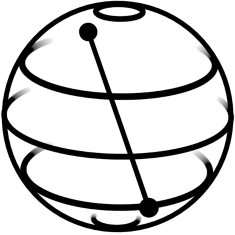
        <br>
        <br>
        Thank you!
    </center>
</div>